## Telco-Churn Rate
 In this project we will build a classification model to predict churn rate for customers who churn that is if customer's are going to leave or not?


 ## Load dataset

In [60]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier

In [61]:
!pip install kaggle

In [62]:
# Make a directory named.kaggle
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [63]:
# Download the dataset
!kaggle datasets download blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [64]:
!unzip telco-customer-churn.zip

Archive:  telco-customer-churn.zip
replace WA_Fn-UseC_-Telco-Customer-Churn.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


In [65]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [66]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [68]:
df.shape

(7043, 21)

## Data Preprocessing

**Checking for missing values**

In [69]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [70]:
df.groupby('Churn')['customerID'].nunique()

Churn
No     5174
Yes    1869
Name: customerID, dtype: int64

Viola we have no missing values. Let us proceed to Exploratoy Data Analysis

## Exploratory Data Analysis

1. **General Churn Rate**

To build a model that predicts customer churn rate, first we need to understand what factors have the greatest impact on the churn of customers from the service. Let's introduce a churn rate(the percentage of customers who churned) and look at it in terms of the characteristics of the customers we have.

In [71]:
fig = px.pie(df.groupby('Churn')['customerID'].nunique().reset_index(),
             values='customerID',
             names='Churn')
fig.show()


26.5% customers churned while 73.5% didn't

2. **Customer's lifetime in the service**

Let's see how many months the clients who are in the churn used our service and is there a point when the largest number of customers stop using the service

In [72]:
fig = px.histogram(df, x="tenure", color="Churn", marginal="box")
fig.show()

In [73]:
df.groupby('Churn')['tenure'].quantile([.50,.75,.90,.95])

Churn      
No     0.50    38.0
       0.75    61.0
       0.90    71.0
       0.95    72.0
Yes    0.50    10.0
       0.75    29.0
       0.90    51.0
       0.95    60.0
Name: tenure, dtype: float64

In [74]:
df.groupby('Churn')['tenure'].mean()

Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64

50% of the customers who left the service did so in the first 10 months.The number of clients in the churn ceases to decline sharply after 5 months in the service

**What were the reasons for the churn mentioned by customers?**

Lets analyze our customer profile data to understand which type of customers are more likely to stop using our service

**Contract types**

Let's see what types of contacts there are in the service and how this affects the churn rate

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [76]:
fig = px.histogram(df, x="Churn", color="Contract", barmode="group",
                   title="Number of customers by contract type")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [77]:
fig = px.pie(df.groupby(['Contract', 'Churn'])['customerID'].count().reset_index(),
             values='customerID',
             names='Contract',
             facet_col = 'Churn',
             title = 'Churn rate by contact type')
fig.show()


88.6% of customers who left the service had a Month-to-month contract type

In [78]:
df.groupby(['Contract','Churn'])['tenure'].mean()

Contract        Churn
Month-to-month  No       21.033333
                Yes      14.016918
One year        No       41.674063
                Yes      44.963855
Two year        No       56.602914
                Yes      61.270833
Name: tenure, dtype: float64

#### Total charges and monthly charges

In [79]:

df.loc[:, 'TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.loc[:, 'MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [81]:
fig = px.histogram(df, x="TotalCharges", color="Churn",
                   marginal="box"
                   )
fig.show()

The median charges of customers who have gone into churn are more than 2 times lower than the median charges of customers who use the service

**Monthly Charges**

In [82]:
fig = px.histogram(df, x="MonthlyCharges", color="Churn",
                   marginal="box"
                  )
fig.show()

In [83]:
df.groupby('Churn')['MonthlyCharges'].quantile([.50,.75,.95,.99])

Churn      
No     0.50     64.4250
       0.75     88.4000
       0.95    108.4175
       0.99    115.1000
Yes    0.50     79.6500
       0.75     94.2000
       0.95    105.6100
       0.99    111.1320
Name: MonthlyCharges, dtype: float64

The median monthly charges of customers who have left the service are higher than those of customers who are still active

**Services used by the client**

We have a flag for each service telling us which service the customer is using The lists is long but we will prioritize by looking at which varibales correlate with the churn variable

In [84]:
corr_df = df.copy()

In [85]:
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [86]:
corr_df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
corr_df['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [87]:
df_dummies = pd.get_dummies(corr_df[['Churn','PhoneService','MultipleLines','InternetService','OnlineSecurity',
                                 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
                                 'StreamingMovies']])
df_dummies = df_dummies.astype(int)
df_dummies.head()

,Churn,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,0,1,0,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0,0,1,1,0,0,1,0,0,0,...,1,1,0,0,1,0,0,1,0,0
2,1,0,1,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,0,1,0,0,1,0,1,0,0,0,...,1,0,0,1,1,0,0,1,0,0
4,1,0,1,1,0,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0


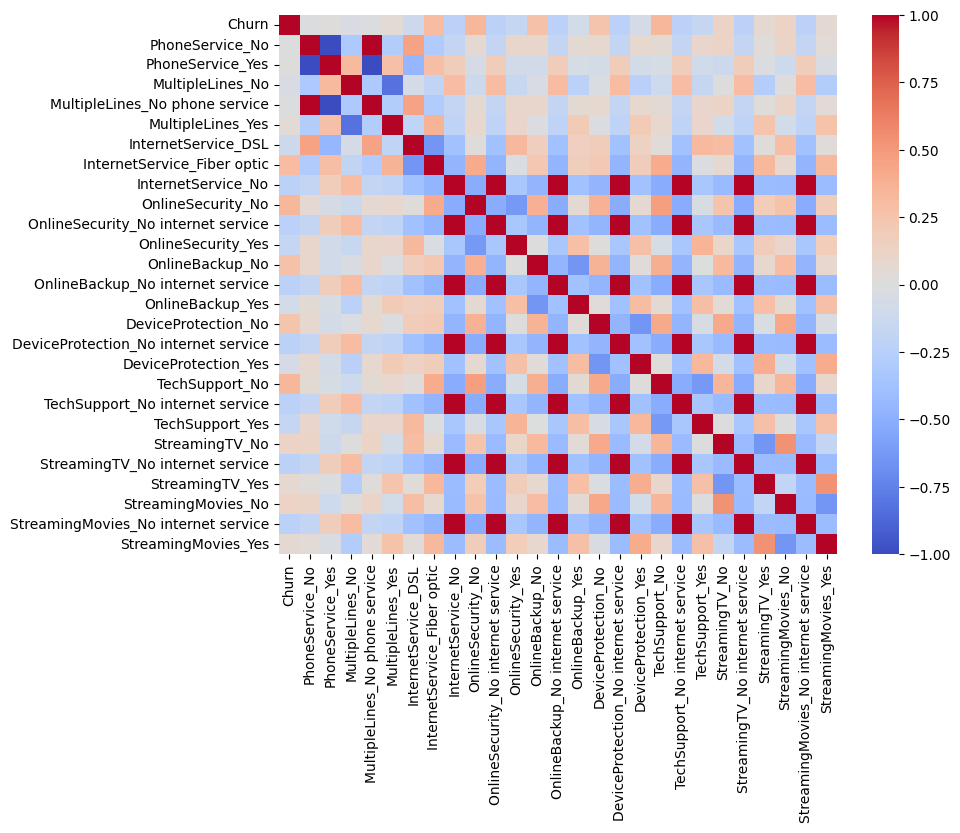

In [88]:
pl.figure(figsize=(9, 7))
sns.heatmap(df_dummies.corr(), annot=False, cmap='coolwarm')

pl.show()

In [89]:
fig = px.bar(df_dummies.corr()['Churn'].sort_values(ascending = False),
             color = 'value')
fig.show()

* fiber optic has a correlation with churn value
* Same as online security and online backup services

#### Internet Services

Let's see what types of internet services customers have, and then let's see their impact on th churn rate


In [90]:
fig = px.bar(df.groupby('InternetService')['customerID'].count().reset_index(),
             x='InternetService',
             y='customerID',
             color = 'InternetService',
             text = 'customerID')
fig.show()

Most clients are connected to the fiber optic internet

Let's see ehat internet services where used by customers who left the service:

In [91]:
fig = px.pie(df.groupby(['InternetService', 'Churn'])['customerID'].count().reset_index(),
             values='customerID',
             facet_col = 'Churn',
             names='InternetService',
             title = 'What type of internet was connected to the clients who left the service?')
fig.show()

69 percent of those who left the service were connected to the fibre optic internet

**Tech support and online security**

In [92]:
# Grouping the data
grouped_data = df.groupby(['InternetService', 'TechSupport', 'Churn'])['customerID'].count().reset_index()

# Creating the plot
fig = px.bar(grouped_data,
             x="InternetService",
             y="customerID",
             color="Churn",
             text='customerID',
             barmode="group",
             facet_col="TechSupport"
            )

# Displaying the plot
fig.show()

Among the clients with fiber optics internet, the percentage of churn is lower for clients with the connected tech support option

In [93]:
fig = px.pie(df.groupby(['TechSupport','Churn'])['customerID'].count().reset_index(),
             values='customerID',
             facet_col = 'Churn',
             hole = .5,
             names='TechSupport',
            title = 'Tech support option and churn')
fig.show()

77.5% of the customers who left the service did not have the tech support option enabled

**Online Security**

In [94]:
fig = px.bar(df.groupby(['InternetService','OnlineSecurity',
                                                'Churn'])['customerID'].count().reset_index(),
             x="InternetService",
             y="customerID",
             color="Churn",
             #barmode="group",
             text = 'customerID',
             facet_col = 'OnlineSecurity'
            )
fig.show()


* The lowest churn rate among customers without Internet services (but there are fewer such customers)

* 69.2% of the clients in the churn were connected to the fiber optic Internet

* The absence of connected technical support and online security options correlates with the churn variable

#### Customer's payment method

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [96]:
fig = px.bar(df.groupby(['PaymentMethod',
                                                'Churn'])['customerID'].count().reset_index(),
             x="customerID",
             y="PaymentMethod",
             color="Churn",
             text = 'customerID'
            )
fig.show()


In [97]:
fig = px.pie(df.groupby(['PaymentMethod','Churn'])['customerID'].count().reset_index(),
            values='customerID',
            names='Churn',
            facet_col = 'PaymentMethod',
            color = 'Churn',
            title = 'Churn rate by customer payment method')

fig.show()

Customers with an electornic check as a payment method have a churn rate of 50%

Let's see if some specific Internet service was used by customers with an electronic check as a means of payment

In [98]:
fig = px.bar(df.groupby(['PaymentMethod', 'InternetService'])['customerID'].count().reset_index(),
             x='PaymentMethod',
             y='customerID',
             facet_col = 'InternetService',
             color = 'customerID',
             text = 'customerID')
fig.show()

Most clients with optical fiber internet used electronic receipt as a means of payment Lets see what the churn rate looks like for the internet service and payment method together

In [99]:
churn_pm = df.assign(churn_clients = np.where(df['Churn']== 'Yes',df['customerID'],None))\
   .groupby(['PaymentMethod','InternetService']).agg({'churn_clients':'count'}).reset_index()


In [100]:
pm_clients = df.groupby(['PaymentMethod','InternetService'])['customerID'].count().reset_index()


In [101]:
pm_data = pm_clients.join(churn_pm.set_index(['PaymentMethod','InternetService']), on=['PaymentMethod','InternetService'])


In [102]:
pm_data

,PaymentMethod,InternetService,customerID,churn_clients
0,Bank transfer (automatic),DSL,566,53
1,Bank transfer (automatic),Fiber optic,646,187
2,Bank transfer (automatic),No,332,18
3,Credit card (automatic),DSL,594,72
4,Credit card (automatic),Fiber optic,597,151
5,Credit card (automatic),No,331,9
6,Electronic check,DSL,648,207
7,Electronic check,Fiber optic,1595,849
8,Electronic check,No,122,15
9,Mailed check,DSL,613,127


In [103]:
pm_data['churn_rate,%'] = round(((pm_data['churn_clients']/pm_data['customerID']) * 100),2)


In [104]:
fig = px.bar(pm_data.sort_values('churn_rate,%'),
             x='churn_rate,%',
             y='PaymentMethod',
             facet_col = 'InternetService',
             color = 'churn_rate,%',
             text = 'churn_rate,%')
fig.show()

We see that for fiber optic internet, churn rates are higher for all payment methods, but the highest is for electronic and mailed checks.We also see that even for Internet DSL, the churn rate for these payment methods is increasing.

At this stage, we found out that the highest churn rate is observed among customers with an electronic check as a means of payment. This behavior is observed for all types of online services, but it is still stronger among customers with optical fiber Internet.

#### Gender and age of clients
**Customer's gender**

In [105]:
fig = px.pie(df.groupby('gender')['customerID'].count().reset_index(),
             values='customerID',
             names='gender',
             color_discrete_sequence=px.colors.sequential.RdBu,
             title = 'Distribution of the clients by gender')
fig.show()


We almost have an equal number of mean and women in the dataset. Let's see of there is a difference in the churn rate

In [106]:
fig = px.bar(df.groupby(['gender',
                                                'Churn'])['customerID'].count().reset_index(),
             x="customerID",
             y="gender",
             color="Churn",
             text = 'customerID'
            )
fig.show()

There's not great difference

**Senior Citizen or not(Age)**

In [107]:
fig = px.pie(df.groupby(['SeniorCitizen','Churn'])['customerID'].count().reset_index(),
            values='customerID',
            names='Churn',
            facet_col = 'SeniorCitizen',
            color = 'Churn',
            title = 'Churn rate by customer age')

fig.show()

The churn rate among senior citizens is almost twice as high as among non-senior citizens. However, there are also much fewer such customers

In [108]:
df.groupby('SeniorCitizen')['customerID'].count()

SeniorCitizen
0    5901
1    1142
Name: customerID, dtype: int64

#### Imapct of having a partner or dependants

In [109]:
fig = px.bar(df.groupby(['SeniorCitizen','Partner',
                                        'Dependents','Churn'])['customerID'].count().reset_index(),
             x="SeniorCitizen",
             y="customerID",
             color="Churn",
             #barmode="group",
             facet_row="Partner",
             facet_col = 'Dependents'
            )
fig.show()

Let's see which services were used by senior citizens and move on to summarizing and building a model for churn prediction

In [110]:
fig = px.bar(df.groupby(['SeniorCitizen','InternetService','Churn'])['customerID'].count().reset_index(),
             x="InternetService",
             y="customerID",
             color="Churn",
             barmode="group",
             facet_col = 'SeniorCitizen'
            )
fig.show()

Among senior citizens, a larger percentage was connected to the optical fiber Internet, and for these customers we see the highest churn rate.

Let's summarize everything we learned after analyzing the data:

* The lowest churn rate among customers without Internet services (but there are fewer such customers)
* 69.2% of the clients in the churn were connected to the fiber optic Internet the absence of connected technical support and online security options correlates with the churn variable
* If we look at the context of customers' payment methods, the highest churn rate is for customers with an electronic check, regardless of the type of Internet services
* The сhurn rate for senior citizens is almost twice as high as for non-senior citizens

## Preparing data for the model
**Changing categorical variables to numeric**

In [111]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [114]:
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)


In [115]:
def encode_data(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [117]:
data = df.apply(lambda x: encode_data(x))
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,74,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,3624,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,536,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,3570,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,674,1


In [119]:
fig = px.bar(data.corr()['Churn'].sort_values(ascending = False),
             color = 'value')
fig.show()

**Balancing the data**

We see that our data is unbalanced and we have more data about customers who are not in churn.

In [120]:
data.groupby('Churn')['Churn'].count()

Churn
0    5174
1    1869
Name: Churn, dtype: int64

Unbalanced data is not good for binary classification because it can lead to biased model performance and inaccurate predictions. If the data is unbalanced, a classifier that always predicts the majority class can achieve a high accuracy rate, but such a model may not be useful in practice. To address this issue, various techniques can be used to balance the data, such as undersampling the majority class or oversampling the minority class. These techniques can help to ensure that the classifier is trained on a more balanced set of data and is therefore better equipped to make accurate predictions on new, unseen data.

We will use the Synthetic Minority Oversampling technique in order to balance our classes

In [121]:
over = SMOTE(sampling_strategy = 1)

x = data.drop("Churn", axis = 1).values
y = data['Churn'].values

In [122]:
x,y = over.fit_resample(x,y)

#### Build a model

In [123]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=2, test_size = 0.2)


In [127]:
def model(method, x_train, y_train, x_test, y_test):
  # Train the model
  method.fit(X_train, y_train)
  # Make predictions on the test data and calculate confusion matrix
  predictions = method.predict(X_test)
  c_matrix = confusion_matrix(y_test, predictions)

  # Calculate label percentages and create label strings with counts and percentages
  percentages = (c_matrix / np.sum(c_matrix, axis = 1)[:, np.newaxis]).round(2) * 100
  labels = [[f"{c_matrix[i, j]}({percentages[i, j]:.2f}%)" for j in range(c_matrix.shape[1])] for i in range(c_matrix.shape[0])]
  labels = np.asarray(labels)

  # Plot confusion matrix with labeled counts and percentages
  sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

  # Evaluate model perfomance and print results
  print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(y_test, predictions)))
  print("Model accuracy: ", '{:.2%}'.format(accuracy_score(y_test, predictions)))
  print(classification_report(y_test, predictions))

We will use Extreme Gradient Boosting Classifier

In [128]:

xgb = XGBClassifier(learning_rate= 0.001, max_depth = 3, n_estimators = 1000)

ROC AUC:  82.07%
Model accuracy:  82.03%
              precision    recall  f1-score   support

           0       0.89      0.74      0.80      1040
           1       0.77      0.90      0.83      1030

    accuracy                           0.82      2070
   macro avg       0.83      0.82      0.82      2070
weighted avg       0.83      0.82      0.82      2070



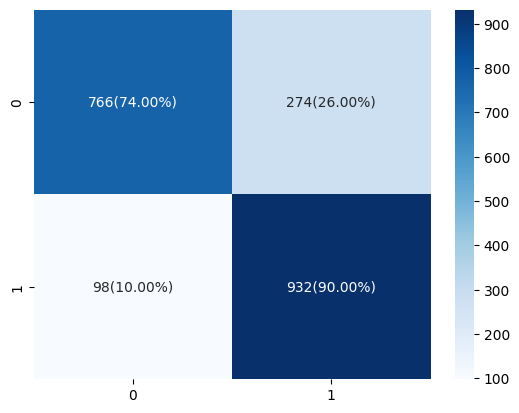

In [129]:
model(xgb, X_train,y_train,X_test,y_test)

**Random Forest Classifier**

ROC AUC:  86.95%
Model accuracy:  86.96%
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1040
           1       0.89      0.85      0.87      1030

    accuracy                           0.87      2070
   macro avg       0.87      0.87      0.87      2070
weighted avg       0.87      0.87      0.87      2070



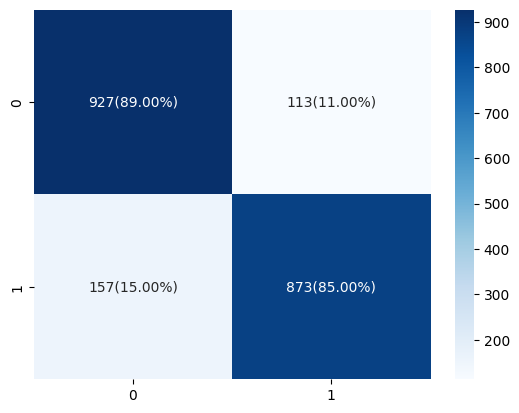

In [130]:
rf = RandomForestClassifier(n_estimators=100, random_state=2)
model(rf, X_train, y_train, X_test, y_test)

**Decision Tree Classifier**

ROC AUC:  81.31%
Model accuracy:  81.30%
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1040
           1       0.81      0.82      0.81      1030

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070



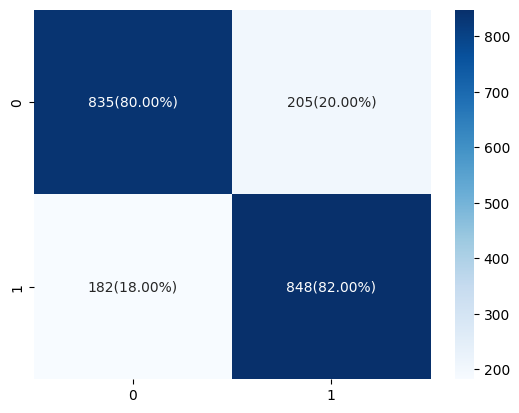

In [131]:
dt = DecisionTreeClassifier(random_state=2)
model(dt, X_train, y_train, X_test, y_test)

## Conclusion

Our models perfomed fairly good with Random forest classifier having the highest accuracy.

In general, for churn prediction, minimizing false negatives (i.e., correctly identifying all customers who are likely to churn) may be more important than minimizing false positives (i.e., incorrectly identifying customers as likely to churn when they are not). So we for business could be more useful to look at F1 score than accuracy, for example. An F1 score of 86% is generally considered to be a good score for a binary classification model. But not perfect and there are a lot of ways to improve it, especially with real customer data.

